In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 


In [4]:
visits = pd.read_csv('visits_log_us.csv')
orders = pd.read_csv('orders_log_us.csv')
costs = pd.read_csv('costs_us.csv')

In [5]:
display(visits.head(), visits.info())
display(orders.head(), orders.info())
display(costs.head(), costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


None

In [6]:
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
visits['End Ts'] = pd.to_datetime(visits['End Ts'])
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower()
costs.columns = costs.columns.str.lower()

visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds() / 60


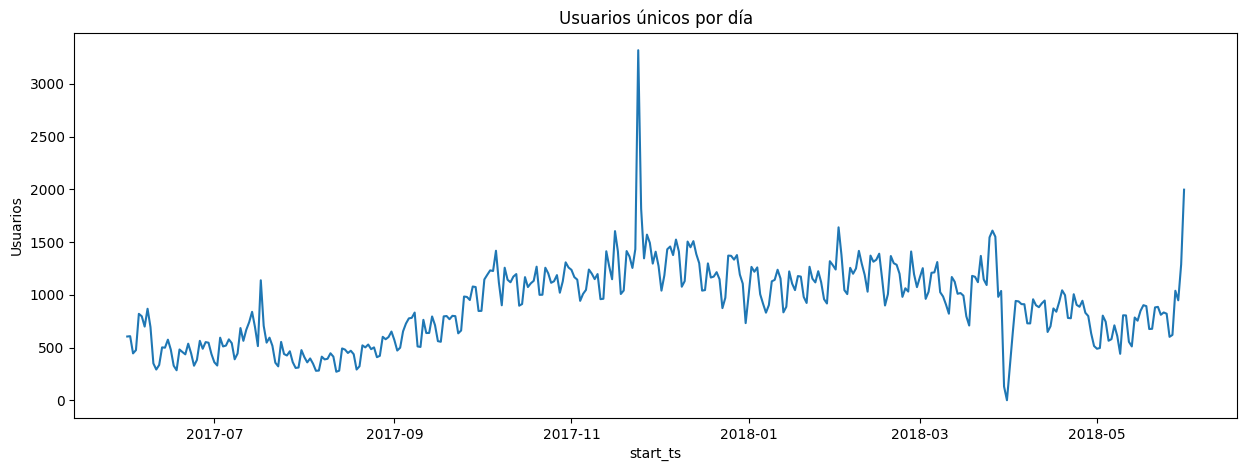

In [7]:
daily_users = visits.groupby(visits['start_ts'].dt.date)['uid'].nunique()
weekly_users = visits.groupby(visits['start_ts'].dt.to_period('W'))['uid'].nunique()
monthly_users = visits.groupby(visits['start_ts'].dt.to_period('M'))['uid'].nunique()

plt.figure(figsize=(15, 5))
daily_users.plot(title='Usuarios únicos por día')
plt.ylabel('Usuarios')
plt.show()


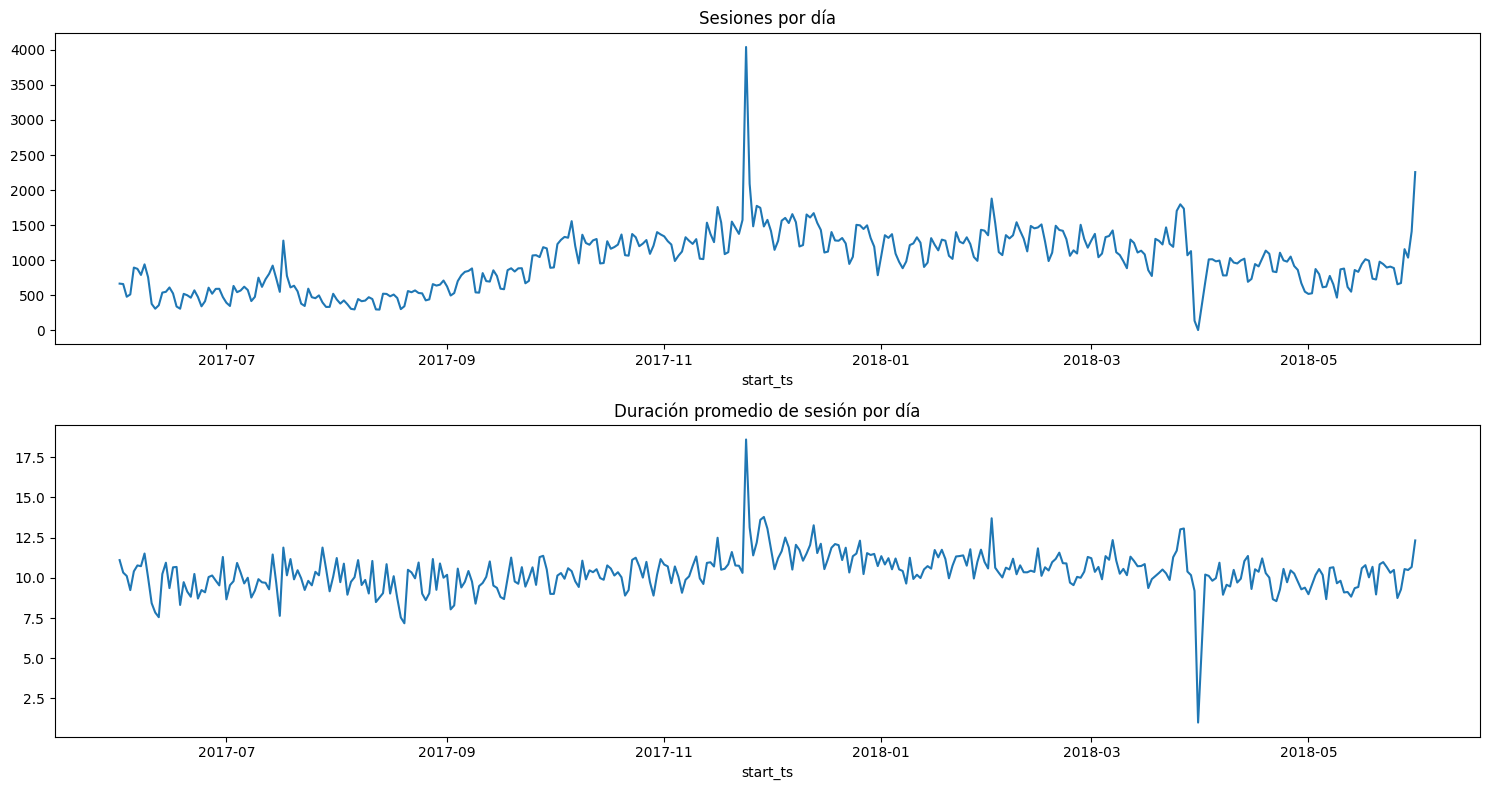

In [8]:
sessions_per_day = visits.groupby(visits['start_ts'].dt.date)['uid'].count()
avg_session_duration = visits.groupby(visits['start_ts'].dt.date)['session_duration'].mean()

fig, ax = plt.subplots(2, 1, figsize=(15, 8))
sessions_per_day.plot(ax=ax[0], title='Sesiones por día')
avg_session_duration.plot(ax=ax[1], title='Duración promedio de sesión por día')
plt.tight_layout()
plt.show()


In [11]:
print(orders.columns)


Index(['buy ts', 'revenue', 'uid'], dtype='object')


In [12]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')


In [13]:
print(orders.columns)


Index(['buy_ts', 'revenue', 'uid'], dtype='object')


In [17]:
ltv = orders.groupby('uid')['revenue'].sum()
ltv.describe()


count    36523.000000
mean         6.901328
std         88.128535
min          0.000000
25%          1.470000
50%          3.050000
75%          5.800000
max      11810.180000
Name: revenue, dtype: float64

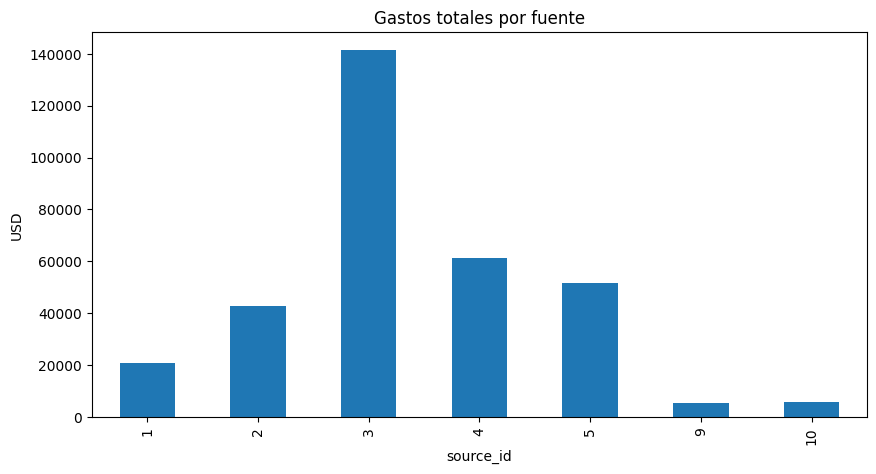

In [18]:
total_costs = costs['costs'].sum()
costs_by_source = costs.groupby('source_id')['costs'].sum()

costs_by_source.plot(kind='bar', figsize=(10,5), title='Gastos totales por fuente')
plt.ylabel('USD')
plt.show()


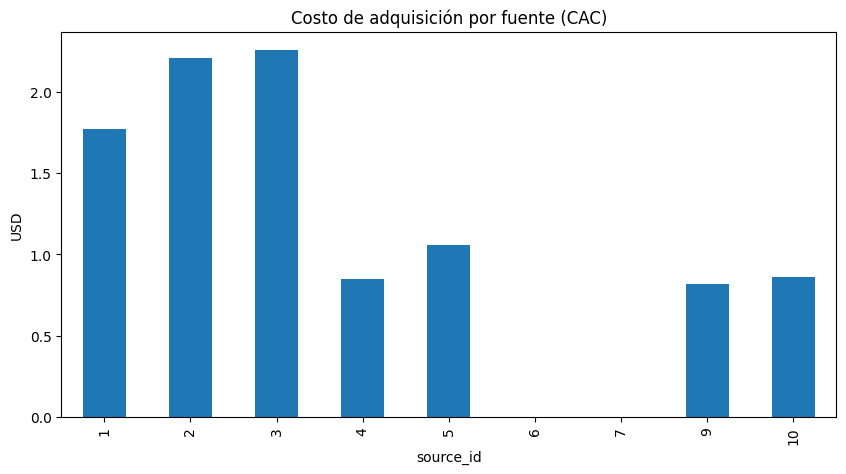

In [19]:
first_visits = visits.groupby('uid')['start_ts'].min().reset_index()
first_visits['first_date'] = first_visits['start_ts'].dt.date
first_visits = first_visits.merge(visits[['uid', 'source_id']], on='uid', how='left').drop_duplicates('uid')

new_users_by_source = first_visits['source_id'].value_counts()
cac = costs_by_source / new_users_by_source

cac.plot(kind='bar', figsize=(10,5), title='Costo de adquisición por fuente (CAC)')
plt.ylabel('USD')
plt.show()


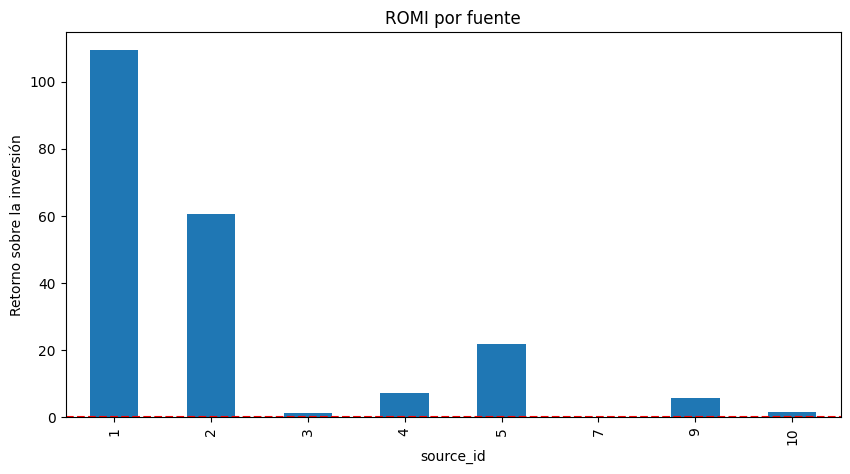

In [20]:
revenue_by_source = visits.merge(orders, on='uid').groupby('source_id')['revenue'].sum()
romi = (revenue_by_source - costs_by_source) / costs_by_source

romi.plot(kind='bar', figsize=(10,5), title='ROMI por fuente')
plt.axhline(0, color='red', linestyle='--')
plt.ylabel('Retorno sobre la inversión')
plt.show()


### Recomendaciones para marketing:

1. **Fuentes rentables**: Las fuentes con mayor ROMI deben priorizarse, especialmente si tienen CAC bajo y LTV alto.
2. **Optimización del presupuesto**: Disminuir inversión en fuentes con CAC alto y ROMI negativo.
3. **Usuarios valiosos**: Analizar características de cohortes con mejor conversión y mayor LTV para futuras campañas.

### Métricas clave utilizadas:

- **ROMI**: retorno sobre inversión en marketing.
- **CAC**: cuánto cuesta adquirir un nuevo cliente.
- **LTV**: ingresos por cliente a lo largo del tiempo.
- **Conversión**: rapidez con la que los usuarios se convierten en compradores.

Este análisis permite tomar decisiones basadas en datos sobre dónde invertir para maximizar la rentabilidad del marketing.
